### Download data

We will download data from NYU box and extract it to local disk. It may take a couple of minutes

In [3]:
! wget -O weather.zip "https://nyu.box.com/shared/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip"

--2021-01-28 14:17:12--  https://nyu.box.com/shared/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Resolving nyu.box.com (nyu.box.com)... 107.152.29.197
Connecting to nyu.box.com (nyu.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip [following]
--2021-01-28 14:17:12--  https://nyu.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip [following]
--2021-01-28 14:17:12--  https://nyu.app.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.29.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [ ]:
! unzip weather.zip

In [3]:
str_path = "./weather/"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from sklearn import linear_model

np.random.seed(2019)

In [2]:
def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print("File name: " + file_name)
    print("Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

In [4]:
load_files = False
if load_files:
    str_path_2015 = str_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = str_path + "hourly/2016/"
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(str_path +"hourly_temperature_2015.npy")
    data_matrix_2016 = np.load(str_path +"hourly_temperature_2016.npy")

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()

### prepare X and y for training

we select a particular city as response variable. You can find indices for some selected cities in the comments. 

In [5]:
ind_response = 31 # 53 = Manhattan, 18 = Troy has 2 correlated features
# 23 = Williams dense linear model 30 = Death Valley
print("Response is " + str(file_name_list[ind_response]))
y_raw = data_matrix[:,ind_response]
y_2016 = data_matrix_2016[:,ind_response]
ind_X = np.hstack((np.arange(0,ind_response),np.arange(ind_response+1,data_matrix.shape[1])))
X_raw = data_matrix[:,ind_X]
X_2016 = data_matrix_2016[:,ind_X]
n_features = X_raw.shape[1]

Response is CRNH0203-2015-CO_Boulder_14_W.txt


In [6]:
n_train_values = 40
n_test = int(1e3)
n_val = int(1e2)
n_train_max = data_matrix.shape[0] - n_test - n_val
n_train_list = np.around(np.logspace(np.log10(n_features),np.log10(n_train_max),n_train_values))
train_error_vec = []

In [7]:
val_error_vec = []
test_error_vec = []
test_2016_vec = []
train_error_ls_vec = []
test_error_ls_vec = []
test_2016_ls_vec = []
train_error_fixed_n_vec = []
val_error_fixed_n_vec = []
coeffs_ls_matrix = np.zeros((n_features,len(n_train_list)))
coeffs_ridge_matrix = np.zeros((n_features,len(n_train_list)))
errs_v = np.zeros((n_features,len(n_train_list)))
lambda_vec = []
sigma_small = []



In [8]:
n_lambda = 40
lambdas_val = np.logspace(-4, 1, n_lambda)
coeffs_fixed_n = np.zeros((n_features,n_lambda))
fixed_n = n_train_list[4]

In [9]:
center_raw = X_raw.mean(axis=0)
X_raw_centered = X_raw - center_raw
col_norms_raw = np.linalg.norm(X_raw_centered, axis=0) / np.sqrt(X_raw.shape[0])
X_raw_norm = np.true_divide(X_raw_centered, col_norms_raw)
true_covariance = np.dot(X_raw_norm.T,X_raw_norm)
v_true, s_true, v_true_h = np.linalg.svd(true_covariance)

### prepare and run multiple ridge regressions

### comparing linear regression and ridge regression

RMSE achieved by the model on the training and test sets, and on the 2016 data, for different number of training data and compares it to the RMSE of least-squares regression.

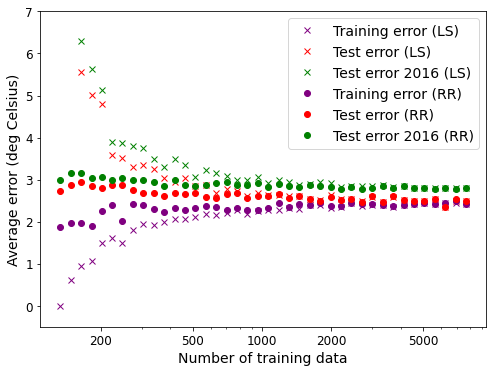

In [11]:
xticks=(np.array([200,500,1000,2000,5000]))
xtick_labels = ('200','500','1000','2000','5000')
plt.figure(figsize=(8,6))
linstyle = 'None'
plt.plot(n_train_list,train_error_ls_vec,linestyle=linstyle,marker='x',color='purple',label="Training error (LS)")
plt.plot(n_train_list,test_error_ls_vec,linestyle=linstyle,marker='x',color='red',label="Test error (LS)")
plt.plot(n_train_list,test_2016_ls_vec,linestyle=linstyle,marker='x',color='green',label="Test error 2016 (LS)")
plt.plot(n_train_list,train_error_vec,linestyle=linstyle,marker='o',color='purple',label="Training error (RR)")
plt.plot(n_train_list,test_error_vec,linestyle=linstyle,marker='o',color='red',label="Test error (RR)")
plt.plot(n_train_list,test_2016_vec,linestyle=linstyle,marker='o',color='green',label="Test error 2016 (RR)")
plt.ylim((-0.5,7))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
plt.legend(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

### λ selected from a validation dataset of size 100 for each number of training data.

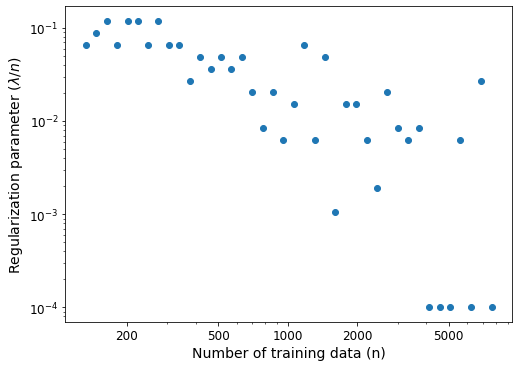

In [12]:
plt.figure(figsize=(8,6))
plt.plot(n_train_list,lambda_vec,marker='o',linestyle='none')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r"Regularization parameter ($\lambda/n$)",fontsize=14)
plt.xlabel('Number of training data (n)',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
# plt.gcf().subplots_adjust(left=0.2)
plt.gcf().subplots_adjust(bottom=0.15)
plt.show()

### Coefficients of the ridge-regression estimator computed from the data for different amount of training data.

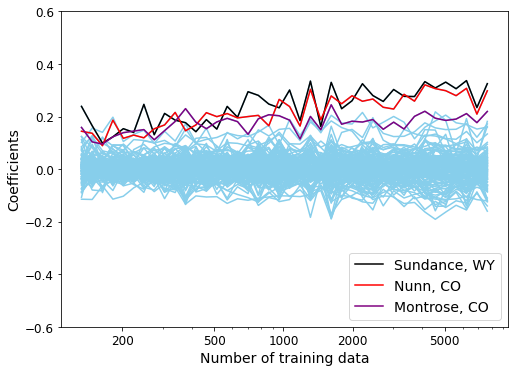

In [13]:
n_largest = 3
color_list = ['black','red','purple','brown','darkgreen']
sorted_coeffs = np.argsort(np.abs(coeffs_ridge_matrix[:,-1]))
largest_coeffs = sorted_coeffs[-1:(-n_largest-1):-1]
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(n_train_list,coeffs_ridge_matrix[ind,:],color='skyblue')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(n_train_list,coeffs_ridge_matrix[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.ylim((-0.6,0.6))
plt.xscale('log')
plt.xlabel('Number of training data',fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.xticks(xticks,xtick_labels)
plt.tick_params(labelsize=12)
#
plt.gcf().subplots_adjust(bottom=0.15)

plt.legend(loc = 'lower right',fontsize=14)
aux_name = file_name_list[ind_response]
aux_name = aux_name[14:]
aux_name = aux_name[:-7]
table = str.maketrans(dict.fromkeys('_0123456789'))
aux_name = aux_name.translate(table)
aux_name = aux_name[2:] + ", " + aux_name[:2]

plt.show()

### the training and validation errors of the ridge-regression estimator applied to the data for different values of the regularization parameter λ. 

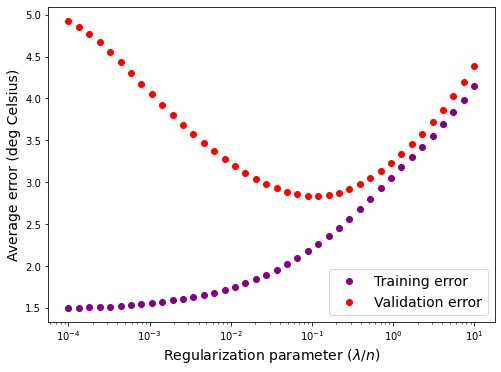

In [14]:
plt.figure(figsize=(8,6))
plt.plot(lambdas_val,train_error_fixed_n_vec,marker='o',linestyle='none',color='purple',label='Training error')
plt.plot(lambdas_val,val_error_fixed_n_vec,marker='o',linestyle='none',color='red',label='Validation error')
plt.xlabel(r"Regularization parameter ($\lambda/n$)",fontsize=14)
plt.ylabel('Average error (deg Celsius)',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xscale('log')
plt.legend(loc = 'lower right',fontsize=14)
plt.show()

### values of the model coefficients for the different λ values.

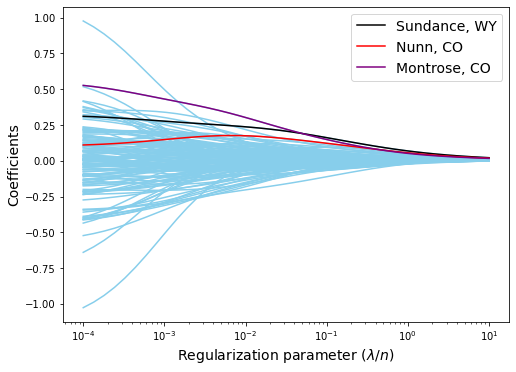

In [15]:
plt.figure(figsize=(8,6))
for ind in range(n_features):
    plt.plot(lambdas_val,coeffs_fixed_n[ind,:],color='skyblue')
    plt.xscale('log')
for ind in range(len(largest_coeffs)):
    ind_name = largest_coeffs[ind]
    if ind_name>=ind_response:
        ind_name = ind_name + 1
    aux_name = file_name_list[ind_name]
    aux_name = aux_name[14:]
    aux_name = aux_name[:-7]
    table = str.maketrans(dict.fromkeys('_0123456789'))
    aux_name = aux_name.translate(table)
    aux_name = aux_name[2:] + ", " + aux_name[:2]
    plt.plot(lambdas_val,coeffs_fixed_n[largest_coeffs[ind],:],color=color_list[ind],label=aux_name)
plt.xlabel(r"Regularization parameter ($\lambda/n$)",fontsize=14)
plt.ylabel('Coefficients',fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15)
plt.legend(loc = 'upper right',fontsize=14)
plt.xscale('log')
plt.show()